In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

%matplotlib inline

In [3]:
def visualise(imgs, rows=2):
    imgs = imgs.transpose(1, 3)
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]

    imgs = (imgs+1)/2  ### valid range   
    
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="cat_136", size=128):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop, y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    def __len__(self):
        return len(self.photo_names)

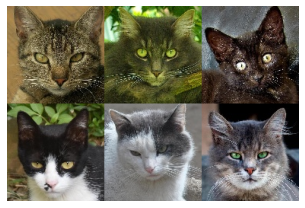

In [7]:
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 4, 6, 11, 13, 14]], dim=0))

# DCGAN

# Generator

In [2]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

In [ ]:
def conv_transe_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.ConvTranspose2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        nn.ReLU())  

In [ ]:
class Generator(nn.Module):
    def __init__(self, start_size=2, latent_channels=32, start_channels=1024, upsamplings=6):
        super(Generator, self).__init__()
        self.start_size = start_size
        self.latent_channels = latent_channels
        self.start_channels = start_channels
        self.upsamplings = upsamplings
        self.fc_features = start_channels // 2**upsamplings
    
        ### in_layer
        self.in_layer = nn.Conv2d(self.latent_channels, self.start_channels, kernel_size=1, stride=1, padding=0, bias=False)
        
        ### upsampling
        self.enc_sizes = [self.start_channels//(2**i) for i in range(self.upsamplings + 1)]
        
        conv_transe_blocks = [conv_transe_block(in_f, out_f, kernel_size=4, stride=2, padding=1, bias=False) 
                       for in_f, out_f in zip(self.enc_sizes[:-1], self.enc_sizes[1:])]
        
        self.encoder = nn.Sequential(*conv_transe_blocks)       
        
        ### out_layer
        self.out_layer = nn.Sequential(
            nn.Conv2d(self.fc_features, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh())

        
    def forward(self, batch_size: int):
        noise = random_noise(batch_size, self.latent_channels, self.start_size)
        out = self.in_layer(noise)
        out = self.encoder(out)
        out = self.out_layer(out)
        return out

# Discriminator

In [ ]:
def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        nn.ReLU())          

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, downsamplings=6, start_channels=8):
        super(Discriminator, self).__init__()
        self.start_channels = start_channels
        self.downsamplings = downsamplings 
        self.fc_features = (start_channels * 128 * 128) // 2**downsamplings
        
        # in layer
        self.in_layer = nn.Conv2d(3, self.start_channels, kernel_size=1, stride=1, padding=0, bias=False)
             
        # последовательность conv2d
        self.enc_sizes = [self.start_channels*(2**i) for i in range(self.downsamplings + 1)]
        
        conv_blocks = [conv_block(in_f, out_f, kernel_size=4, stride=2, padding=1, bias=False) ### (3, 2, 1)
                       for in_f, out_f in zip(self.enc_sizes[:-1], self.enc_sizes[1:])]
        
        self.encoder = nn.Sequential(*conv_blocks)    
                
        # out layer
        self.flt = nn.Flatten()
        self.out_layer = nn.Sequential(
            nn.Linear(self.fc_features, 1, bias=False),
            nn.Sigmoid())     
        
        
    def forward(self, x):
        out = self.in_layer(x)
        out = self.encoder(out)
        out = self.flt(out)
        out = self.out_layer(out)
        return out

# Train

In [ ]:
def train_gan():
    generator = Generator()
    discriminator = Discriminator()
    epochs = 120
    visualise_every = 10
    batch_size = 8
    generator.cuda()
    discriminator.cuda()

    gen_optim = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    disc_optim = Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    dataset = CatDataset(size=128)

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        gen_loss_avg = 0
        disc_loss_avg = 0

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            
            # Positive update
            batch = batch.cuda()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Negative update
            batch = generator(batch_size).detach()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.zeros_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Generator update
            batch = generator(batch_size)
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_loss_avg += loss.item()
        
        if (ep + 1) % visualise_every == 0:
            with torch.no_grad():
                visualise(generator(6), rows=2)

        print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")


Epoch 1 | Discriminator loss: 0.34241024235803785 | Generator loss: 4.969453078619441



Epoch 2 | Discriminator loss: 0.6194433725055059 | Generator loss: 3.4578467663493218



Epoch 3 | Discriminator loss: 0.8249573191701614 | Generator loss: 2.684791332816485



Epoch 4 | Discriminator loss: 0.8089895207891877 | Generator loss: 2.612809899662222



Epoch 5 | Discriminator loss: 0.7659568004592131 | Generator loss: 2.7500995018559955



Epoch 6 | Discriminator loss: 0.6958169258913308 | Generator loss: 2.8759940874687633



Epoch 7 | Discriminator loss: 0.586714589670597 | Generator loss: 3.3403186792079707



Epoch 8 | Discriminator loss: 0.5164820734634367 | Generator loss: 3.663418070314834



Epoch 9 | Discriminator loss: 0.47825028804551684 | Generator loss: 3.8369763877173386


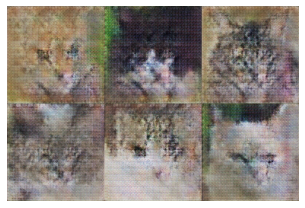

Epoch 10 | Discriminator loss: 0.4182842906137249 | Generator loss: 4.059296236402407



Epoch 11 | Discriminator loss: 0.3932979467804357 | Generator loss: 4.167418277134066



Epoch 12 | Discriminator loss: 0.40701300575883637 | Generator loss: 4.269907697665025



Epoch 13 | Discriminator loss: 0.3841387360519757 | Generator loss: 4.2629880919959975



Epoch 14 | Discriminator loss: 0.34348687488306245 | Generator loss: 4.701053450265841



Epoch 15 | Discriminator loss: 0.3351496841831261 | Generator loss: 4.5025786323073715



Epoch 16 | Discriminator loss: 0.3194680961238779 | Generator loss: 4.880787088749757



Epoch 17 | Discriminator loss: 0.3470015333300213 | Generator loss: 4.497976198283411



Epoch 18 | Discriminator loss: 0.30803882080086026 | Generator loss: 4.73757018493662



Epoch 19 | Discriminator loss: 0.3444010496785561 | Generator loss: 4.611004735649742


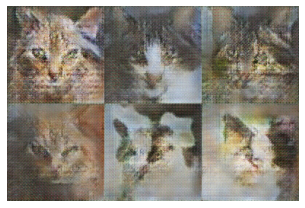

Epoch 20 | Discriminator loss: 0.3315108049732404 | Generator loss: 4.753104367958648



Epoch 21 | Discriminator loss: 0.3187064720736829 | Generator loss: 4.647103276751611



Epoch 22 | Discriminator loss: 0.31789155768752686 | Generator loss: 4.698807177243766



Epoch 23 | Discriminator loss: 0.3178477875862218 | Generator loss: 4.866423979274327



Epoch 24 | Discriminator loss: 0.27718288982600964 | Generator loss: 5.0515265882200335



Epoch 25 | Discriminator loss: 0.3080484602379881 | Generator loss: 4.796802873659578



Epoch 26 | Discriminator loss: 0.3031792992389162 | Generator loss: 5.189229239495645



Epoch 27 | Discriminator loss: 0.2883318747931256 | Generator loss: 4.83021922722482



Epoch 28 | Discriminator loss: 0.30095989026412173 | Generator loss: 4.98777286930484



Epoch 29 | Discriminator loss: 0.29558030890761106 | Generator loss: 4.934165147185233


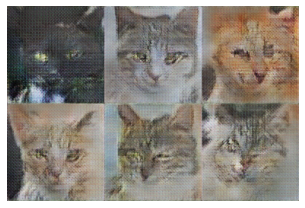

Epoch 30 | Discriminator loss: 0.2933703674858486 | Generator loss: 4.952527771640268



Epoch 31 | Discriminator loss: 0.2419254169813962 | Generator loss: 5.330795981568394



Epoch 32 | Discriminator loss: 0.283895904881681 | Generator loss: 4.901684695102784



Epoch 33 | Discriminator loss: 0.30227969031743357 | Generator loss: 4.843527758389897



Epoch 34 | Discriminator loss: 0.23744075878256857 | Generator loss: 5.029108621133781



Epoch 35 | Discriminator loss: 0.24315539232481664 | Generator loss: 5.4195851442514



Epoch 36 | Discriminator loss: 0.2764502565611326 | Generator loss: 5.0973188423129345



Epoch 37 | Discriminator loss: 0.2664792511832317 | Generator loss: 5.084315906909311



Epoch 38 | Discriminator loss: 0.2790301678460531 | Generator loss: 5.247300928146203



Epoch 39 | Discriminator loss: 0.27080210731871324 | Generator loss: 4.951323615433359


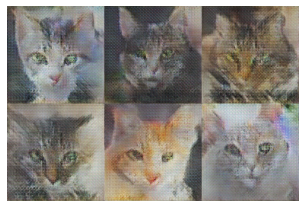

Epoch 40 | Discriminator loss: 0.2583247014814432 | Generator loss: 5.372714694427407



Epoch 41 | Discriminator loss: 0.23365313475010904 | Generator loss: 5.316891461610794



Epoch 42 | Discriminator loss: 0.25409698344528264 | Generator loss: 5.2603880464105135



Epoch 43 | Discriminator loss: 0.24573296523878105 | Generator loss: 5.23953517544899



Epoch 44 | Discriminator loss: 0.2544805242827724 | Generator loss: 5.464748832796301



Epoch 45 | Discriminator loss: 0.2310749109243326 | Generator loss: 5.52728329443876



Epoch 46 | Discriminator loss: 0.2607620651443704 | Generator loss: 5.34935414481052



Epoch 47 | Discriminator loss: 0.22710694527492212 | Generator loss: 5.349426649464584



Epoch 48 | Discriminator loss: 0.23887450432115626 | Generator loss: 5.2471958591215175



Epoch 49 | Discriminator loss: 0.21979231058457144 | Generator loss: 5.400377646111739


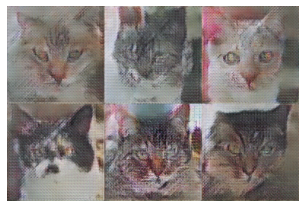

Epoch 50 | Discriminator loss: 0.20525663117524504 | Generator loss: 5.719322132606129



Epoch 51 | Discriminator loss: 0.23572473191943438 | Generator loss: 5.787755351409501



Epoch 52 | Discriminator loss: 0.21086616480088016 | Generator loss: 5.370218328761388



Epoch 53 | Discriminator loss: 0.2119274225395931 | Generator loss: 5.6035969053505



Epoch 54 | Discriminator loss: 0.2152659596295088 | Generator loss: 5.432619355942892



Epoch 55 | Discriminator loss: 0.22216991397804753 | Generator loss: 5.8557317326342835



Epoch 56 | Discriminator loss: 0.2093218013332219 | Generator loss: 5.536199720055791



Epoch 57 | Discriminator loss: 0.2531992395553013 | Generator loss: 5.557196653777768



Epoch 58 | Discriminator loss: 0.21929085818576471 | Generator loss: 5.362915486907181



Epoch 59 | Discriminator loss: 0.2642703800069696 | Generator loss: 5.3159454963314605


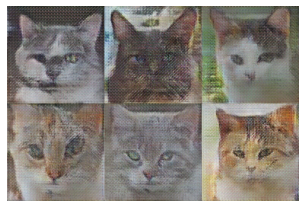

Epoch 60 | Discriminator loss: 0.2035244643181371 | Generator loss: 5.644841804348442



Epoch 61 | Discriminator loss: 0.20150430165896327 | Generator loss: 5.911872116281934



Epoch 62 | Discriminator loss: 0.1901091327800307 | Generator loss: 5.755517519177487



Epoch 63 | Discriminator loss: 0.23084952759494423 | Generator loss: 5.744054016605112



Epoch 64 | Discriminator loss: 0.20608396455005693 | Generator loss: 5.682962277545507



Epoch 65 | Discriminator loss: 0.23507889935483797 | Generator loss: 5.6429251459664345



Epoch 66 | Discriminator loss: 0.18057586270120252 | Generator loss: 5.952836940146011



Epoch 67 | Discriminator loss: 0.206583868603046 | Generator loss: 5.910418114746395



Epoch 68 | Discriminator loss: 0.20279685796994487 | Generator loss: 5.854032329705931



Epoch 69 | Discriminator loss: 0.20493646204138677 | Generator loss: 5.986654176087529


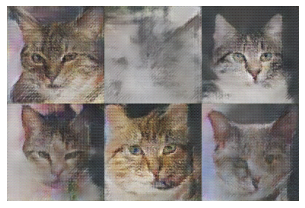

Epoch 70 | Discriminator loss: 0.19529071528457717 | Generator loss: 5.806086837250438



Epoch 71 | Discriminator loss: 0.20064272095654537 | Generator loss: 5.646490048640263



Epoch 72 | Discriminator loss: 0.20014967857633637 | Generator loss: 5.657530119445939



Epoch 73 | Discriminator loss: 0.23518086994177917 | Generator loss: 5.637721219510766



Epoch 74 | Discriminator loss: 0.2148120694331646 | Generator loss: 5.493673962081048



Epoch 75 | Discriminator loss: 0.17256100452963197 | Generator loss: 5.766934306077335



Epoch 76 | Discriminator loss: 0.21404388524432505 | Generator loss: 5.819020152508472



Epoch 77 | Discriminator loss: 0.1879785304218229 | Generator loss: 5.682106871458685



Epoch 78 | Discriminator loss: 0.21455917259143087 | Generator loss: 5.76579212068771



Epoch 79 | Discriminator loss: 0.1964870739096884 | Generator loss: 5.674722613338728


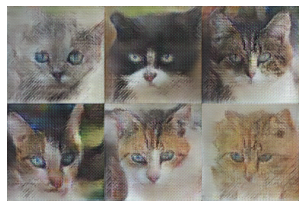

Epoch 80 | Discriminator loss: 0.1684082080499528 | Generator loss: 5.984854730667535



Epoch 81 | Discriminator loss: 0.1859301613559386 | Generator loss: 5.9909802160185315



Epoch 82 | Discriminator loss: 0.19732285544958025 | Generator loss: 5.845207475229913



Epoch 83 | Discriminator loss: 0.19585745572250393 | Generator loss: 6.015278111472263



Epoch 84 | Discriminator loss: 0.19237980698937007 | Generator loss: 5.8847448155746696



Epoch 85 | Discriminator loss: 0.1809288063354971 | Generator loss: 6.199452012557513



Epoch 86 | Discriminator loss: 0.19957553171165537 | Generator loss: 6.0244353772227806



Epoch 87 | Discriminator loss: 0.18271827425572568 | Generator loss: 6.034120629223422



Epoch 88 | Discriminator loss: 0.1880132970727698 | Generator loss: 6.052642012605015



Epoch 89 | Discriminator loss: 0.1891715694159874 | Generator loss: 5.9265566112022405


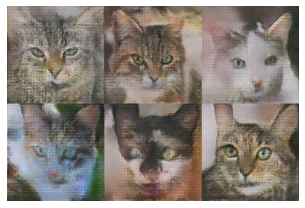

Epoch 90 | Discriminator loss: 0.17455813386654814 | Generator loss: 6.0668545295455445



Epoch 91 | Discriminator loss: 0.19217346646511013 | Generator loss: 6.186497232610626



Epoch 92 | Discriminator loss: 0.18133018722196023 | Generator loss: 5.86668990274764



Epoch 93 | Discriminator loss: 0.17978195910680625 | Generator loss: 6.078301899273943



Epoch 94 | Discriminator loss: 0.1596062794908731 | Generator loss: 6.073141910089469



Epoch 95 | Discriminator loss: 0.16478686719120808 | Generator loss: 6.271411996913252



Epoch 96 | Discriminator loss: 0.2013445725352963 | Generator loss: 6.233731546063231



Epoch 97 | Discriminator loss: 0.17674836985671868 | Generator loss: 5.986585055378133



Epoch 98 | Discriminator loss: 0.15597257889641097 | Generator loss: 6.349383900532071



Epoch 99 | Discriminator loss: 0.17764985049430448 | Generator loss: 6.6736197264066766


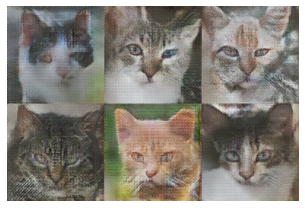

Epoch 100 | Discriminator loss: 0.17999957374229966 | Generator loss: 6.342269241994953



Epoch 101 | Discriminator loss: 0.16981667242611279 | Generator loss: 6.157338972833956



Epoch 102 | Discriminator loss: 0.13443338245914743 | Generator loss: 6.439368548091524



Epoch 103 | Discriminator loss: 0.17662607043973994 | Generator loss: 6.125823399618916



Epoch 104 | Discriminator loss: 0.1564931058918268 | Generator loss: 6.43726383714202



Epoch 105 | Discriminator loss: 0.15487791292080336 | Generator loss: 6.42429315473491



Epoch 106 | Discriminator loss: 0.12827655590452341 | Generator loss: 6.523145110710807



Epoch 107 | Discriminator loss: 0.16069003179284103 | Generator loss: 6.543176913483543



Epoch 108 | Discriminator loss: 0.14482768072272037 | Generator loss: 6.54668142350379



Epoch 109 | Discriminator loss: 0.15647226666461173 | Generator loss: 6.5858495235443115


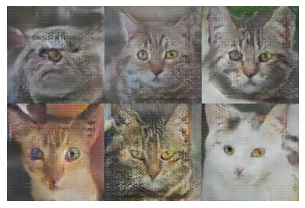

Epoch 110 | Discriminator loss: 0.16255095772912706 | Generator loss: 6.525466346858729



Epoch 111 | Discriminator loss: 0.13594387131823127 | Generator loss: 6.7967295847277835



Epoch 112 | Discriminator loss: 0.14000943729579904 | Generator loss: 7.040977271215886



Epoch 113 | Discriminator loss: 0.15788313647637892 | Generator loss: 6.7722710230798455



Epoch 114 | Discriminator loss: 0.1325725241584401 | Generator loss: 6.429244770905616



Epoch 115 | Discriminator loss: 0.1539154245745273 | Generator loss: 6.86575173794853



Epoch 116 | Discriminator loss: 0.13342875903101484 | Generator loss: 6.716929955003054



Epoch 117 | Discriminator loss: 0.17176485725950433 | Generator loss: 6.475112277794606



Epoch 118 | Discriminator loss: 0.16149075921971093 | Generator loss: 6.62203496662171



Epoch 119 | Discriminator loss: 0.14573826659843014 | Generator loss: 7.05159523254781


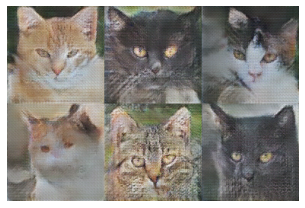

Epoch 120 | Discriminator loss: 0.14943743016140182 | Generator loss: 6.633982196589064


In [ ]:
train_gan()